In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Ecobee Thermostat Data Pre-Processing

In [3]:
# Benign traffic

et_benign = pd.read_csv('nbaiot/Ecobee_Thermostat/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_et_benign = et_benign.copy(deep=True)

columns = list(df_et_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)

df_et_benign = pd.DataFrame(df_et_benign, columns = chosen_columns)

# Mirai

et_mirai_ack = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_ack = et_mirai_ack.copy(deep=True)
df_et_mirai_ack = pd.DataFrame(df_et_mirai_ack, columns = chosen_columns)

et_mirai_scan = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_scan = et_mirai_scan.copy(deep=True)
df_et_mirai_scan = pd.DataFrame(df_et_mirai_scan, columns = chosen_columns)

et_mirai_syn = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_syn = et_mirai_syn.copy(deep=True)
df_et_mirai_syn = pd.DataFrame(df_et_mirai_syn, columns = chosen_columns)

et_mirai_udp = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udp = et_mirai_udp.copy(deep=True)
df_et_mirai_udp = pd.DataFrame(df_et_mirai_udp, columns = chosen_columns)

et_mirai_udpplain = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udpplain = et_mirai_udpplain.copy(deep=True)
df_et_mirai_udpplain = pd.DataFrame(df_et_mirai_udpplain, columns = chosen_columns)

# Bashlite

et_bashlite_combo = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_combo = et_bashlite_combo.copy(deep=True)
df_et_bashlite_combo = pd.DataFrame(df_et_bashlite_combo, columns = chosen_columns)

et_bashlite_junk = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_junk = et_bashlite_junk.copy(deep=True)
df_et_bashlite_junk = pd.DataFrame(df_et_bashlite_junk, columns = chosen_columns)

et_bashlite_scan = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_scan = et_bashlite_scan.copy(deep=True)
df_et_bashlite_scan = pd.DataFrame(df_et_bashlite_scan, columns = chosen_columns)

et_bashlite_udp = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_udp = et_bashlite_udp.copy(deep=True)
df_et_bashlite_udp = pd.DataFrame(df_et_bashlite_udp, columns = chosen_columns)

et_bashlite_tcp = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_tcp = et_bashlite_tcp.copy(deep=True)
df_et_bashlite_tcp = pd.DataFrame(df_et_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_et_benign_norm = scaler.fit_transform(df_et_benign)

df_et_miraiack_norm = scaler.fit_transform(df_et_mirai_ack)
df_et_miraiscan_norm = scaler.fit_transform(df_et_mirai_scan)
df_et_miraisyn_norm = scaler.fit_transform(df_et_mirai_syn)
df_et_miraiudp_norm = scaler.fit_transform(df_et_mirai_udp)
df_et_miraiudpplain_norm = scaler.fit_transform(df_et_mirai_udpplain)

df_et_bashlitecombo_norm = scaler.fit_transform(df_et_bashlite_combo)
df_et_bashlitejunk_norm = scaler.fit_transform(df_et_bashlite_junk)
df_et_bashlitescan_norm = scaler.fit_transform(df_et_bashlite_scan)
df_et_bashliteudp_norm = scaler.fit_transform(df_et_bashlite_udp)
df_et_bashlitetcp_norm = scaler.fit_transform(df_et_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_et_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_et_benign_norm[:len_benign_train]

# Test set - 30% of the benign set and the rest is attack

X_test_benign = df_et_benign_norm[len_benign_train:]

X_test_mirai_ack = df_et_miraiack_norm
X_test_mirai_scan = df_et_miraiscan_norm
X_test_mirai_syn = df_et_miraisyn_norm
X_test_mirai_udp = df_et_miraiudp_norm
X_test_mirai_udpplain = df_et_miraiudpplain_norm
X_test_bashlite_combo = df_et_bashlitecombo_norm
X_test_bashlite_junk = df_et_bashlitejunk_norm
X_test_bashlite_scan = df_et_bashlitescan_norm
X_test_bashlite_tcp = df_et_bashlitetcp_norm
X_test_bashlite_udp = df_et_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 250
learning_rate = 0.0001
batch_size = 20
anomaly_threshold = 0.05
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11)           264         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            84          dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 7)            84          dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                88        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                276       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 23)]              0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 432       
_________________________________________________________________
decoder (Functional)         (None, 23)                364       
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 9179 samples
Epoch 1/250
9179/9179 [==============================] - 1s 152us/sample - loss: 69.6112
Epoch 2/250
9179/9179 [==============================] - 1s 128us/sample - loss: 45.3688
Epoch 3/250
9179/9179 [==============================] - 1s 126us/sample - loss: 24.5369
Epoch 4/250
9179/9179 [==============================] - 1s 127us/sample - loss: 13.5572
Epoch 5/250
9179/9179 [==============================] - 1s 129us/sample - loss: 9.6435
Epoch 6/250
9179/9179 [==============================] - 1s 128us/sample - loss: 8.0138
Epoch 7/250
9179/9179 [==============================] - 1s 128us/sample - loss: 7.1389
Epoch 8/250
9179/9179 [==============================] - 1s 127us/sample - loss: 6.6100
Epoch 9/250
9179/9179 [==============================] - 1s 128us/sample - loss: 6.3132
Epoch 10/250
9179/9179 [==============================] - 1s 128us/sample - loss: 6.0242
Epoch 11/250
9179/9179 [==============================] - 1s 129us/sample - loss: 5.8043
Epoc

9179/9179 [==============================] - 1s 128us/sample - loss: 2.3697
Epoch 93/250
9179/9179 [==============================] - 1s 126us/sample - loss: 2.3940
Epoch 94/250
9179/9179 [==============================] - 1s 129us/sample - loss: 2.3924
Epoch 95/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.3710
Epoch 96/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.3677
Epoch 97/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.3497
Epoch 98/250
9179/9179 [==============================] - 1s 126us/sample - loss: 2.3641
Epoch 99/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.3376
Epoch 100/250
9179/9179 [==============================] - 1s 130us/sample - loss: 2.3413
Epoch 101/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.3541
Epoch 102/250
9179/9179 [==============================] - 1s 126us/sample - loss: 2.3476
Epoch 103/250
9179/9179 [======

9179/9179 [==============================] - 1s 126us/sample - loss: 2.1665
Epoch 184/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1632
Epoch 185/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1446
Epoch 186/250
9179/9179 [==============================] - 1s 129us/sample - loss: 2.1606
Epoch 187/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.1602
Epoch 188/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1684
Epoch 189/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1480
Epoch 190/250
9179/9179 [==============================] - 1s 125us/sample - loss: 2.1380
Epoch 191/250
9179/9179 [==============================] - 1s 127us/sample - loss: 2.1411
Epoch 192/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1346
Epoch 193/250
9179/9179 [==============================] - 1s 128us/sample - loss: 2.1500
Epoch 194/250
9179/9179 

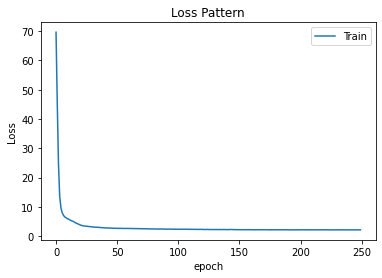

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 30.882164239883423
[False False False ...  True  True  True]


0.9960348229157721

In [15]:
print(len(X_test_VAE))

826697


# Metrics

In [16]:
sys.stdout = open("Results/ecobee_thermostat.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate and anomaly threshold ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [19]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [20]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [21]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'